# Week 5 GAN: Description
In this challenge, we will create a Generative Adversarial Network (GAN) to generate images in the style of Monet. A basic GAN consists of two neural networks, a generator model and discriminator model. The generator generates the images, and the discriminator trains the generator. They compete against each other where the discriminator tries to classify generated images as real vs fake. Once the discriminator can't tell the difference, the generator has reached sufficient training and should generate realistic images. In this challenge, the metric to be evaluated at that point is MiFID (Memorization-informed Frechet Inception Distance). The smaller MiFID is, the better the generated images are. In this challenge we will generate 7,000 to 10,000 Monet-style images. We'll use tensorflow and keras frequently throughout our models.

In [20]:
# Import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from kaggle_datasets import KaggleDatasets
from PIL import Image
import shutil
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import collections

In [2]:
# Load in filenames and other photo size info
file_dir = KaggleDatasets().get_gcs_path()
monet_filenames = tf.io.gfile.glob(str(file_dir + '/monet_tfrec/*.tfrec'))
photo_filenames = tf.io.gfile.glob(str(file_dir + '/photo_tfrec/*.tfrec'))
image_size = [256, 256]
output_channels = 3
batch_size = 1

2023-02-18 20:57:53.301649: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-02-18 20:57:53.350904: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [3]:
# Set up TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
autotune = tf.data.experimental.AUTOTUNE

2023-02-18 20:57:53.402687: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-18 20:57:53.406233: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-02-18 20:57:53.406275: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-18 20:57:53.406298: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (30857640dab6): /proc/driver/nvidia/version does not exist
2023-02-18 20:57:53.410548: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Device: grpc://10.0.0.2:8470


# Exploratory Data Analysis
There are 4 folders of datasets that come with this challenge. Half of the images are Monet paintings, and half are regular photographs. These paintings and photographs come in both in TFRecord and JPEG format. The TFRecord format is an efficient format for large and complex datasets, that stores the data in a sequence of binary records. First let's preview the images in JPEG format. Each image is 256x256 RGB pixels.

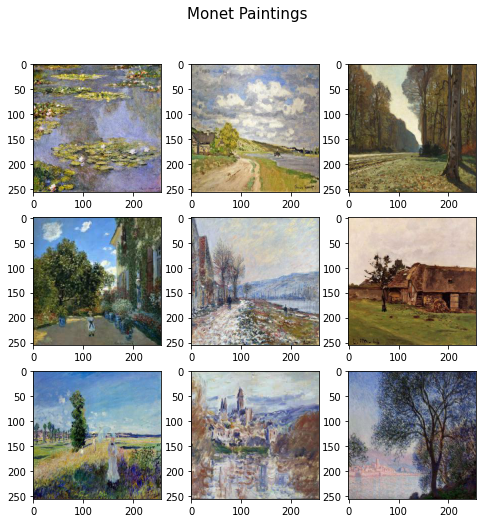

In [4]:
# Preview images
tmp, ax = plt.subplots(3,3, figsize=(8,8))
plt.suptitle('Monet Paintings', fontsize=15)
index = 0 
for i in range(3):
    for j in range(3):
        ax[i][j].imshow(Image.open('../input/gan-getting-started/monet_jpg/'+os.listdir('../input/gan-getting-started/monet_jpg')[index]))
        index = index + 1

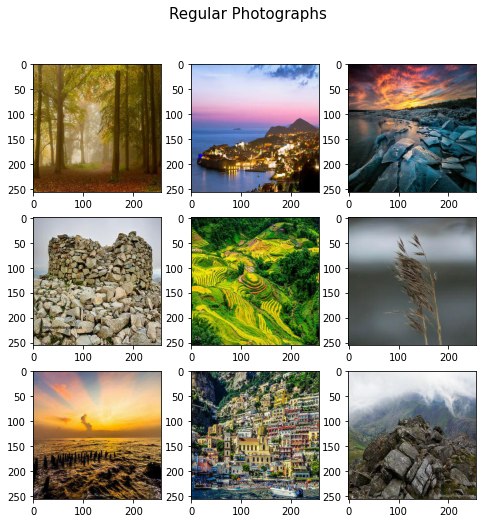

In [5]:
# Preview images
tmp, ax = plt.subplots(3,3, figsize=(8,8))
plt.suptitle('Regular Photographs', fontsize=15)
index = 0 
for i in range(3):
    for j in range(3):
        ax[i][j].imshow(Image.open('../input/gan-getting-started/photo_jpg/'+os.listdir('../input/gan-getting-started/photo_jpg')[index]))
        index = index + 1

Next we'll create some helper functions to read in the TFRecord files and convert them for our network. We'll convert to a uint8 tensor, then 32 bit float, and normalize it so that all the values are between -1 and 1. We'll reshape it to 256x256x3 pixels. Last, we'll augment the data (apply random transformations like rotations to diversify the training data) and batch the data given the batch size.

In [6]:
# Create helper functions for reading in data
def convert_image(image):
    image = tf.image.decode_jpeg(image, channels=output_channels)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*image_size, output_channels])
    return image

def read_tf(tf_file):
    tfrecord_format = {"image": tf.io.FixedLenFeature([], tf.string)}
    example = tf.io.parse_single_example(tf_file, tfrecord_format)
    image = convert_image(example['image'])
    return image

def data_augment(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)
    return image

def load_data(filenames,batch_size):
    datafiles = tf.data.TFRecordDataset(filenames)
    datafiles = datafiles.map(read_tf, num_parallel_calls=autotune)
    datafiles = datafiles.map(data_augment, num_parallel_calls=autotune)
    return datafiles.batch(batch_size)

In [7]:
# Read in data, combine and zip
monet_ds = load_data(monet_filenames,batch_size)
photo_ds = load_data(photo_filenames,batch_size)
combined_dataset = tf.data.Dataset.zip((monet_ds, photo_ds))

# Model Architecture
As previously discussed, we'll use a GAN to create Monet style images. Since this is a style transfer challenge, we will specifically use a CycleGAN, which is well suited for this problem and images. A CycleGAN is made up of two generator models and two discriminator models. Each generator is used to generate images in the 2 different domains, and each has a corresponding discriminator. We'll create a common architecture for each generator and discriminator.

First, we'll create functions (layers) to be used for downsampling and upsampling of the data. In the downsample layer, we'll have a 2D convolutional layer with stride 2, with an optional input for instance normalization. We'll end with a leaky Relu activation function. The Leaky Relu will output the value if positive, and apply a slope if negative. In the upsample layer, we'll start with a 2D convolutional transpose layer, with stride 2, and instance normalization. We'll have an optional dropout layer, and end with a Relu activation function. The Relu with output the value if positive, otherwise 0. These downsample and upsample layers make up the encoder parts of the cycle GAN.

In [8]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0, 0.02)
    normal_init = keras.initializers.RandomNormal(mean=0, stddev=0.02)
    layer = keras.Sequential()
    layer.add(layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_instancenorm:
        layer.add(tfa.layers.InstanceNormalization(gamma_initializer=normal_init))
    layer.add(layers.LeakyReLU())
    return layer

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0, 0.02)
    normal_init = keras.initializers.RandomNormal(mean=0, stddev=0.02)
    layer = keras.Sequential()
    layer.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer,use_bias=False))
    layer.add(tfa.layers.InstanceNormalization(gamma_initializer=normal_init))
    if apply_dropout:
        layer.add(layers.Dropout(0.5))
    layer.add(layers.ReLU())
    return layer

Next, we'll create the Generator and Discriminator classes, made up of upsample and downsample layers. We'll include skip connections in the generator to address the vanishing gradient problem. The last layer of the generator includes a tanh activation function to keep the data between -1 and 1. The Discriminator is made up of downsample layers, zero padding, 2D convolutional layers, and a leaky relu activation function.

In [9]:
def Generator():
    
    # Input
    inp = layers.Input(shape=[256,256,3])

    # Downsample layers
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),                        
        downsample(256, 4),                                             
        downsample(512, 4),    
        downsample(512, 4),
        downsample(512, 4),                      
        downsample(512, 4),                      
    ]

    # Upsample layers
    up_stack = [  
        upsample(512, 4, apply_dropout=True),    
        upsample(512, 4, apply_dropout=True),    
        upsample(512, 4),                          
        upsample(256, 4),                         
        upsample(128, 4),                           
        upsample(64, 4),                           
    ]

    # Final layer with tanh activation
    initializer = tf.random_normal_initializer(0, 0.02)
    final = layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh') 

    # Skip connections in downsample
    x = inp
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    # Skip connections in upsample
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    x = final(x)

    return keras.Model(inputs=inp, outputs=x)

In [10]:
def Discriminator():
    
    # Input
    initializer = tf.random_normal_initializer(0, 0.02)
    norm_init = keras.initializers.RandomNormal(mean=0, stddev=0.02)
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    
    # Downsample layers
    x = inp
    d1 = downsample(64, 4, False)(x)       
    d2 = downsample(128, 4)(d1)        
    d3 = downsample(256, 4)(d2)        

    # 2D conv layer with zero padding
    zero_pad1 = layers.ZeroPadding2D()(d3)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)
    
    # Leaky relu, zero padding, and 2D conv layer
    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=norm_init)(conv)
    leaky_relu = layers.LeakyReLU()(norm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    final = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=final)

In [11]:
# Create instances for 2 generators and 2 discriminators for the CycleGAN
with strategy.scope():
    monet_generator = Generator()
    photo_generator = Generator()
    monet_discriminator = Discriminator()
    photo_discriminator = Discriminator()

Now, we'll create the cycle GAN class using the generators and discriminators we just created. We'll compute the losses for each, and apply the gradients to the optimizers. I've borrowed and modified this CycleGAN class code, since it's fairly complicated, from a tensorflow tutorial, found here: https://www.tensorflow.org/tutorials/generative/cyclegan

In [12]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator, 
        lambda_cycle=10, 
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        batch_size = tf.shape(real_monet)[0]
        with tf.GradientTape(persistent=True) as tape:
        
            # photograph to monet painting back to photograph
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet painting to photograph back to monet painting
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True) 
            
            # discriminator checked against real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator checked against fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)
            
            # compute generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # compute total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # compute total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            
            # compute discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate gradients for the generators and discriminators
        monet_generator_grads = tape.gradient(total_monet_gen_loss,self.m_gen.trainable_variables)
        photo_generator_grads = tape.gradient(total_photo_gen_loss,self.p_gen.trainable_variables)
        monet_discriminator_grads = tape.gradient(monet_disc_loss,self.m_disc.trainable_variables)
        photo_discriminator_grads = tape.gradient(photo_disc_loss,self.p_disc.trainable_variables)
        
        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_grads,self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_grads,self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_grads,self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_grads,self.p_disc.trainable_variables))
        
        # Return losses
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

Below we define the loss functions to be used in the above CycleGAN class. The discriminator and generator loss functions use Binary Cross Entropy loss which compares each predicted probability to the actual class output, which is either a 0 or 1. The output score penalizes the probabilities depending on the distance from the expected value. The identity loss is meant to capture that if you run the monet-to-photo model on a photo or photo-to-monet model on a monet, it should not modify the image much.

In [13]:
# Define loss functions
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5
    
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss1
    
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

Next, we define the optimizers to be used during training, and some initial hyperparameters. These defaults also come from the tensor flow tutorial. An adam optimizer is fairly common for a cycle GAN.

In [14]:
# Define optimizers
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [15]:
# Compile cycle GAN model
with strategy.scope():
    cycle_gan_model = CycleGan(monet_generator, photo_generator, monet_discriminator, photo_discriminator)
    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

# Results and Analysis
Now that we've built and compiled our cycle GAN, we are ready to train the model. We'll start with 30 epochs and investigate the losses. This should train fairly fast since we are utilizing the TPU resources.

In [16]:
# Train the model
trained_gan = cycle_gan_model.fit(combined_dataset, epochs=30)

Epoch 1/30
300/300 [==============================] - 121s 119ms/step - monet_gen_loss: 4.4713 - photo_gen_loss: 4.6290 - monet_disc_loss: 0.6413 - photo_disc_loss: 0.6025
Epoch 2/30
  1/300 [..............................] - ETA: 51s - monet_gen_loss: 2.6050 - photo_gen_loss: 2.3042 - monet_disc_loss: 0.6726 - photo_disc_loss: 0.5738

2023-02-18 21:00:12.410650: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 11600, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1676754012.407202507","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 11600, Output num: 0","grpc_status":3}


300/300 [==============================] - 36s 119ms/step - monet_gen_loss: 3.2913 - photo_gen_loss: 3.5106 - monet_disc_loss: 0.6527 - photo_disc_loss: 0.5756
Epoch 3/30
300/300 [==============================] - 36s 119ms/step - monet_gen_loss: 3.2218 - photo_gen_loss: 3.4346 - monet_disc_loss: 0.6430 - photo_disc_loss: 0.5782
Epoch 4/30
300/300 [==============================] - 36s 119ms/step - monet_gen_loss: 3.2160 - photo_gen_loss: 3.3861 - monet_disc_loss: 0.6298 - photo_disc_loss: 0.6088
Epoch 5/30
300/300 [==============================] - 36s 119ms/step - monet_gen_loss: 3.1894 - photo_gen_loss: 3.3260 - monet_disc_loss: 0.6234 - photo_disc_loss: 0.6114
Epoch 6/30
300/300 [==============================] - 36s 119ms/step - monet_gen_loss: 3.1837 - photo_gen_loss: 3.3567 - monet_disc_loss: 0.6193 - photo_disc_loss: 0.5750
Epoch 7/30
300/300 [==============================] - 36s 119ms/step - monet_gen_loss: 3.1338 - photo_gen_loss: 3.2274 - monet_disc_loss: 0.6077 - photo_dis

2023-02-18 21:17:45.875864: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 99357, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1676755065.875763535","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 99357, Output num: 0","grpc_status":3}


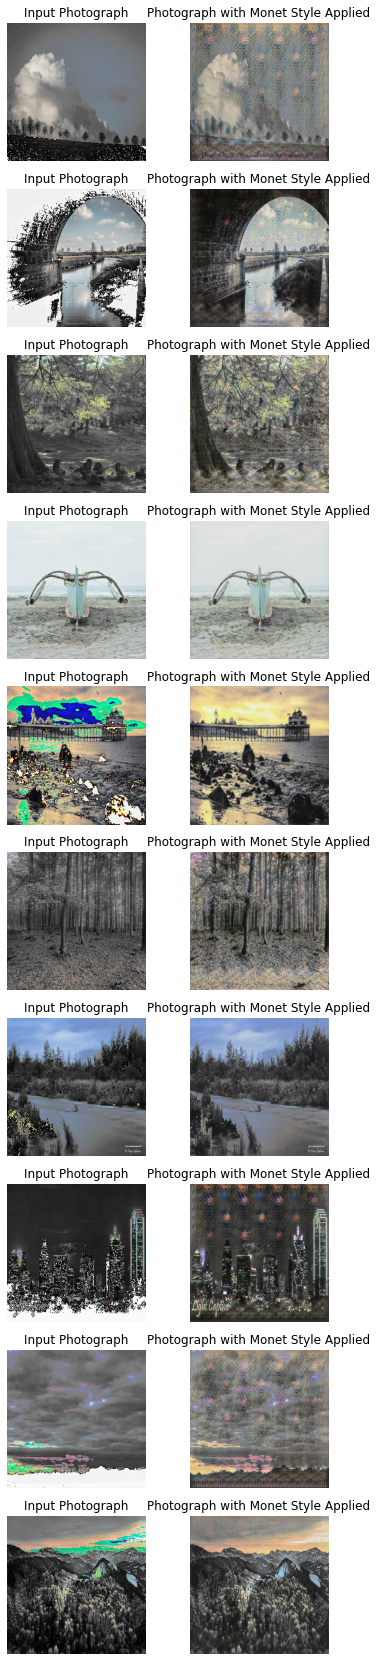

In [17]:
# Inspect transferred images       
tmp, ax = plt.subplots(10, 2, figsize=(6, 30))
for i, img in enumerate(photo_ds.take(10)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photograph")
    ax[i, 1].set_title("Photograph with Monet Style Applied")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

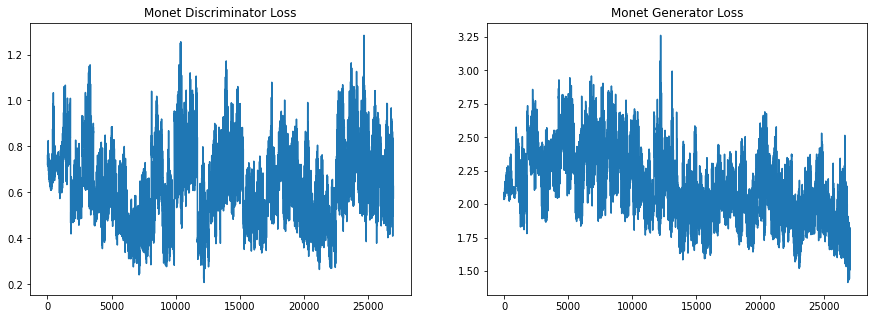

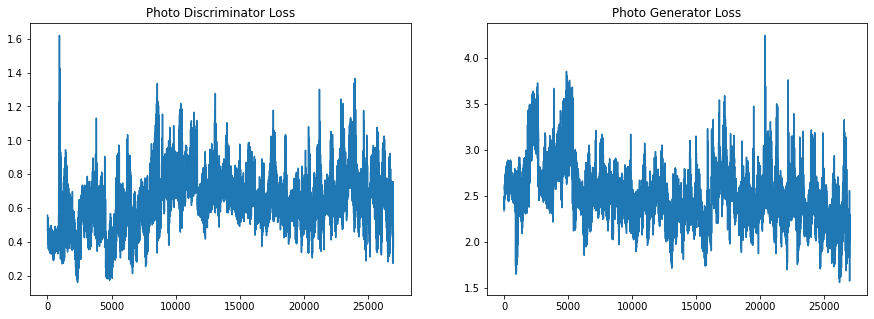

In [18]:
# Inspect losses
def flatten(l):
    for el in l:
        if isinstance(el, collections.abc.Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el
monet_disc_loss = trained_gan.history['monet_disc_loss']
monet_disc_loss = list(flatten(monet_disc_loss))
monet_gen_loss = trained_gan.history['monet_gen_loss']
monet_gen_loss = list(flatten(monet_gen_loss))
photo_disc_loss = trained_gan.history['photo_disc_loss']
photo_disc_loss = list(flatten(photo_disc_loss))
photo_gen_loss = trained_gan.history['photo_gen_loss']
photo_gen_loss = list(flatten(photo_gen_loss))

# Monet
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sb.lineplot(data=monet_disc_loss, ax=ax[0])
ax[0].set_title('Monet Discriminator Loss')
sb.lineplot(data=monet_gen_loss, ax=ax[1])
ax[1].set_title('Monet Generator Loss')
fig.show()

# Photo
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sb.lineplot(data=photo_disc_loss, ax=ax[0])
ax[0].set_title('Photo Discriminator Loss')
sb.lineplot(data=photo_gen_loss, ax=ax[1])
ax[1].set_title('Photo Generator Loss')
fig.show()

# Conclusions
In inspecting our losses, the generator and discriminators have done fairly well over 30 epochs. In inspecting some example images, they are definitely starting to look more like Monet paintings, but not 100% convincing yet. Some ideas for improving this CycleGAN are batch normalization or modifying the activation functions. I had originally trained without data augmentation, and when adding that in (random rotations, contrast changes, etc) that significantly improved the losses.

Now, we are ready to submit. Our submission will be evaluated based on MiFID (memorization-informed frechet inception distance). The smaller the MiFID, the better our generated images are. Kaggle will utilize the pre-trained neural network Inception to calculate MiFID scores. We need to zip our images into one output file named images.zip.

In [ ]:
# Submit results
! mkdir ../images
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")